## Orfium Assessment - Text Normalization

#### Our approach combines regex-based text preprocessing with spaCy's NER capabilities to normalize raw writer data effectively.
Steps:
- Initial Cleaning: Unified delimiters and removed unwanted patterns (e.g., numeric placeholders, irrelevant keywords).
- Entity Recognition: Used spaCy to identify PERSON entities and validate segments.
- Heuristic Processing: Reordered names with commas and retained multi-word meaningful segments.
- Normalization: Aggregated validated segments into a single normalized string.

In [33]:
#### Install the multilingual model of spacy
#!python -m spacy download xx_ent_wiki_sm

In [34]:
import pandas as pd
import numpy as np
import re
import spacy

In [35]:
# Loading the dataset
df = pd.read_csv("normalization_assesment_dataset_10k.csv", encoding='utf-8')
print("Data loaded. Number of rows:", len(df))

Data loaded. Number of rows: 10000


In [36]:
print(df.head(10))

                               raw_comp_writers_text  \
0            Jordan Riley/Adam Argyle/Martin Brammer   
1                                      Martin Hygård   
2  Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...   
3                                     Mendel Brikman   
4                                          Alvin Lee   
5                        Haddag Samir/MusicAlligator   
6                                       Mefi Morales   
7                                 Christopher Franke   
8                            UNKNOWN WRITER (999990)   
9                                    Shashank Katkar   

                                          CLEAN_TEXT  
0            Jordan Riley/Adam Argyle/Martin Brammer  
1                                      Martin Hygård  
2  Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...  
3                                                NaN  
4                                          Alvin Lee  
5                                       Haddag Samir 

In [37]:
# spaCy initialization
nlp = spacy.load("xx_ent_wiki_sm")

### Exclusion Keywords and Regex Patterns

In [38]:
# Common placeholders for unknown info, publishers or references and numeric placeholders 
keywords_to_exclude = {
    "0",
    "nan",
    "none",
    "traditional",
    "public domain",
    "various artists",
    "writer unknown",
    "#unknown#",
    "unknown writer",
    "unknown",
    "copyright control",
    "copyright",
    "control",
    "bmi",
    "ascap",
    "zaiks",
    "boosey & hawkes",
    "music publishing",
    "publishing", 
    "district 6 music publishing ltd",
    "sony/atv music publishing",
    "blue stamp music",
    "musicalligator",
    "perf by",
    "label",
    "records",
    "record",
    "license",
    "license pending",
    "publishing (uk) limited",
    "999990",
    "999999",
    "9999",
    "999",
}

# Regex patterns
regex_patterns = [
    re.compile(r"\(.*?\)"),    # remove bracketed text like (UK), (999990), etc.
    re.compile(r"^\d+$"),      # exclude strings that are only digits
    re.compile(r"^\W+$"),      # exclude strings of only non-alphanumeric chars
]

### Basic Cleaning

In [39]:
def remove_perf_by_phrases(segment: str) -> str:
    """
    Removes "(PERF BY ...)" and "(performed by ...)" phrases in a segment.
    """
    segment = re.sub(r"\(.*?\b(PERF BY|performed by)\b.*?\)", "", segment, flags=re.IGNORECASE)
    return segment.strip()

def basic_clean(segment: str) -> str:
    """
    Cleans a single string segment by applying regex-based exclusions,
    removing unwanted parentheses, and trimming whitespace.
    """
    # Remove "(PERF BY ...)" or "(performed by ...)" phrases
    segment = remove_perf_by_phrases(segment)
    
    # Apply exclusion regexes
    for regex in regex_patterns:
        segment = regex.sub("", segment)

    # Trim whitespace after any modifications
    segment = segment.strip()
    return segment

def keyword_excluded(segment: str) -> bool:
    """
    Checks if the segment contains exclusion keywords or is part of known patterns to skip.
    """
    seg_lower = segment.lower()
    for keyword in keywords_to_exclude:
        # A given segment (seg_lower) matches a specific keyword (keyword) or whether the keyword is a substring of the segment,
        # provided that the segment consists of only a single word
        if seg_lower == keyword or (keyword in seg_lower and len(seg_lower.split()) == 1):
            return True
    return False

def name_reorder(segment: str) -> str:
    """
    Reorders names in "Lastname, Firstname" format to "Firstname Lastname".
    """
    if segment.count(",") == 1:
        parts = [p.strip() for p in segment.split(",")]
        return parts[1] + " " + parts[0]
    return segment

In [40]:
def normalization(original_text: str) -> str:
    """
    Normalizes raw composition writer text by cleaning, reordering names, and filtering out
    unwanted entities like publishers or placeholders.
    """

    # Check the validity of the input original_text to ensure it is a non-empty string
    if not isinstance(original_text, str) or not original_text.strip():
        return ""

    # Unify delimiters to "/" - Replaces inconsistent delimiters in original_text with a unified delimiter, /
    temp_value = re.sub(r"[,&]+", "/", original_text)

    # Split the cleaned string (temp_value) into individual segments (names or entities) and removes any empty or whitespace-only segments
    segments = [s.strip() for s in temp_value.split("/") if s.strip()]

    # Initialize an empty list which will store the final validated and normalized names or entities after further processing
    retained_names = []

    # Iterateg Over Segments
    for seg in segments:

        # Apply a cleaning function to the segment, which removes unwanted characters or noise (parentheses or special characters)
        seg_clean = basic_clean(seg)
        if not seg_clean:
            continue

        # Exclude known placeholders/publishers
        if keyword_excluded(seg_clean):
            continue

        # spaCy Named Entity Recognition (NER) ---------------------------------------
        doc = nlp(seg_clean)
        person_entity = False
        org_or_gpe_entity = False

        # Identify named entities (doc.ents) in the text and flags:
        if doc.ents:

            # Iterating over the text and flag
            for ent in doc.ents:
                # If the entity is labeled as ORG (organization) or GPE (geopolitical entity)
                if ent.label_ in ("ORG", "GPE"):
                    org_or_gpe_entity = True
                # If the entity is labeled as person and its length is at least half of the original segment length
                if ent.label_ == "PERSON" and len(ent.text) >= 0.5 * len(seg_clean):
                    person_entity = True
        
        # If a person nameis found apply name_reorder and add the finalized segment to the list
        if person_entity:
            final_section = name_reorder(seg_clean)
            retained_names.append(final_section)
        
        # If an organization or geopolitical entity is found
        else:
            # If the segment is recognized as an ORG or GPE
            if org_or_gpe_entity:
                # Split the segment into words
                words = seg_clean.split()

                # If it contains only one word add it to retained_names without further processing
                if len(words) == 1:
                    retained_names.append(seg_clean)
                # If it contains multiple words retain the entire segment
                else:
                    retained_names.append(seg_clean)
            
            # Handling Non-Recognized Entities for segments that are neither person nor ORG/GPE
            else:
                # Count the number of alphabetic characters
                letters_only = re.findall(r"[A-Za-z]", seg_clean)
                # If the segment contains at least two alphabetic characters
                if len(letters_only) >= 2:
                    # Apply name_reorder() to reorder names if needed
                    final_section = name_reorder(seg_clean)
                    # Add the segment to retained_names
                    retained_names.append(final_section)

    return "/".join(retained_names)

In [41]:
# Create the normalized_text column:
df["normalized_text"] = df["raw_comp_writers_text"].apply(normalization)

### Results

In [42]:
print("\nSample of Normalized Results:\n")
print(df[["raw_comp_writers_text", "normalized_text"]].head(30))


Sample of Normalized Results:

                                raw_comp_writers_text  \
0             Jordan Riley/Adam Argyle/Martin Brammer   
1                                       Martin Hygård   
2   Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...   
3                                      Mendel Brikman   
4                                           Alvin Lee   
5                         Haddag Samir/MusicAlligator   
6                                        Mefi Morales   
7                                  Christopher Franke   
8                             UNKNOWN WRITER (999990)   
9                                     Shashank Katkar   
10                           L. Chandler/John Hammond   
11                        Itsjaygocrazy/Jordan Ancrum   
12              Ferhan C/Aaron Tyler/Blue Stamp Music   
13                                      Mike Kalambay   
14                                     Rikard Sjöblom   
15                                   Junior Francisco   

In [43]:
df.head(10)

,raw_comp_writers_text,CLEAN_TEXT,normalized_text
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN,Mendel Brikman
4,Alvin Lee,Alvin Lee,Alvin Lee
5,Haddag Samir/MusicAlligator,Haddag Samir,Haddag Samir
6,Mefi Morales,Mefi Morales,Mefi Morales
7,Christopher Franke,Christopher Franke,Christopher Franke
8,UNKNOWN WRITER (999990),NaN,
9,Shashank Katkar,Shashank Katkar,Shashank Katkar


#### Export normalized dataframe

In [44]:
df.to_csv("normalized_output.csv", index=False, encoding='utf-8')

## Metrics: Exact Match & Partial Match

In [45]:
import matplotlib.pyplot as plt
from collections import Counter

def jaccard_similarity(str1, str2):
    """
    Computes Jaccard similarity between two slash-separated sets of tokens.
    Example: "Mike Hoyer/JERRY CHESNUT" vs. "JERRY CHESNUT/Mike Hoyer".
    If both sets are empty, we return 1.0 (treat as 'match'), 
    but you could choose 0.0 if you prefer.
    """
    set1 = set(str1.split("/"))
    set2 = set(str2.split("/"))
    if not set1 and not set2:
        return 1.0  # Both empty => treat as perfect match
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union else 0.0


# Compute columns for comparison
df["exact_match"] = (df["normalized_text"] == df["CLEAN_TEXT"]).astype(int)

# Compute Jaccard similarity for partial overlaps
df["jaccard"] = df.apply(
    lambda row: jaccard_similarity(
        str(row["normalized_text"] or ""), 
        str(row["CLEAN_TEXT"] or "")
    ),
    axis=1
)

# Calculate summary statistics
exact_matches = df["exact_match"].sum()
total_rows   = len(df)
avg_jaccard  = df["jaccard"].mean()

print(f"Number of rows: {total_rows}")
print(f"Exact matches:  {exact_matches} ({(100.0 * exact_matches / total_rows):.2f}% )")
print(f"Average Jaccard similarity: {avg_jaccard:.3f}")

Number of rows: 10000
Exact matches:  7550 (75.50% )
Average Jaccard similarity: 0.791


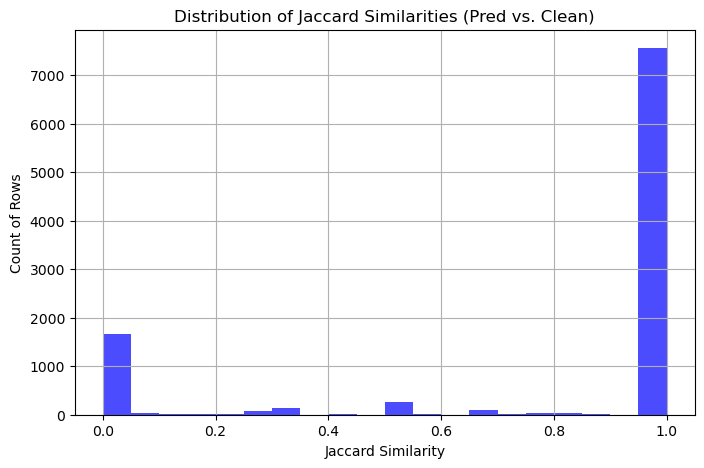

In [46]:
# Plot a histogram of Jaccard similarities
plt.figure(figsize=(8,5))
df["jaccard"].hist(bins=20, alpha=0.7, color='blue')
plt.title("Distribution of Jaccard Similarities (Pred vs. Clean)")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count of Rows")
plt.show()

In [47]:
# Inspect "failed" or "low-similarity" cases
threshold = 0.3  # define your threshold for "low" overlap
fails = df[df["jaccard"] < threshold]
print(f"\nRows with jaccard < {threshold}:")
print(fails[["raw_comp_writers_text", "CLEAN_TEXT", "normalized_text", "jaccard"]].head(10))


Rows with jaccard < 0.3:
                                raw_comp_writers_text  \
3                                      Mendel Brikman   
8                             UNKNOWN WRITER (999990)   
22                                  NS (PERF BY KALI)   
25                                             fo man   
27                                        Traditional   
28                                          #unknown#   
46                                   AARON D SPRINKLE   
63  Adam Pék/Cory James/Various Artists/Copyright...   
66                       Aleksandr Alekseevich Osipov   
69                                          渡辺徹/森月キャス   

                    CLEAN_TEXT                  normalized_text  jaccard  
3                          NaN                   Mendel Brikman     0.00  
8                          NaN                                      0.00  
22           NS (PERF BY KALI)                               NS     0.00  
25                         NaN                

## Example Outputs

In [48]:
df[["raw_comp_writers_text", "CLEAN_TEXT", "normalized_text"]].head(50)

,raw_comp_writers_text,CLEAN_TEXT,normalized_text
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN,Mendel Brikman
4,Alvin Lee,Alvin Lee,Alvin Lee
5,Haddag Samir/MusicAlligator,Haddag Samir,Haddag Samir
6,Mefi Morales,Mefi Morales,Mefi Morales
7,Christopher Franke,Christopher Franke,Christopher Franke
8,UNKNOWN WRITER (999990),NaN,
9,Shashank Katkar,Shashank Katkar,Shashank Katkar
